# Predicting Car Fuel Consumption

In this example we are going to create a regression model with Keras Tensorflow which aims to predict the efficiency of a fleet of cars.

The dataset can be found at:

[Auto MPG Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/)

We are going to put in practice some techniques to tackle this regresion problem, like "bucketizing" numerical features.

Also though it is a rather simple problem, we will apply some best practices in terms of choices for initialization, callbacks, hyperparameter tunning, optimizer, batch size, learning rate, dropout etc...


In [2]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import seaborn as sns
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


## Import Dataset

In [3]:
# The dataset can be read directly from the url, or if you do not have connection, from a local folder like ../data

#url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

path = '../data/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Attribute Information:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete


## Dataset Preprocesssing

In [4]:
# Count NaN
print(df.isnull().sum())

# As there are only 6 null values we drop them in a new dataframe
df_clean = df.dropna().reset_index(drop=True)
df_clean.head()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
df_clean_copy = df_clean.copy()
df_clean_copy['Origin'] = df_clean_copy['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df_clean_copy = pd.get_dummies(df_clean_copy, columns=['Origin'], prefix='', prefix_sep='')
df_clean_copy.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Feature Importance Calculation

In the following cells we calculate the influence of the input variables over the MPG (miles per gallon), which is the intended variable to be predicted.

The results are the same with both procedures.

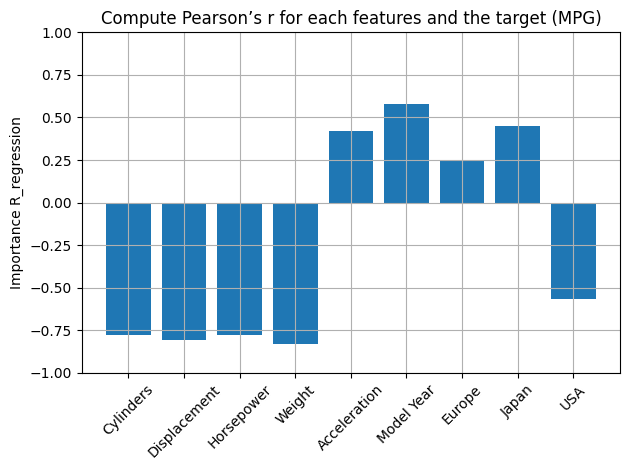

In [6]:
from sklearn.feature_selection import r_regression
# For further information on r_regression look at:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html#sklearn.feature_selection.r_regression

X= df_clean_copy.iloc[:,1:].values
y = df_clean_copy.iloc[:,0].values
importances = r_regression(X, y, center=True, force_finite=True)

fig, ax = plt.subplots()
ax.bar(range(9), importances, align = 'center')
ax.set_ylabel('Importance R_regression')
ax.set_xticks(range(9))
ax.set_xticklabels(df_clean_copy.columns[1:], rotation = 45)
plt.title('Compute Pearson’s r for each features and the target (MPG)')
plt.ylim([-1,1])
plt.tight_layout()
plt.grid(True)
plt.show()

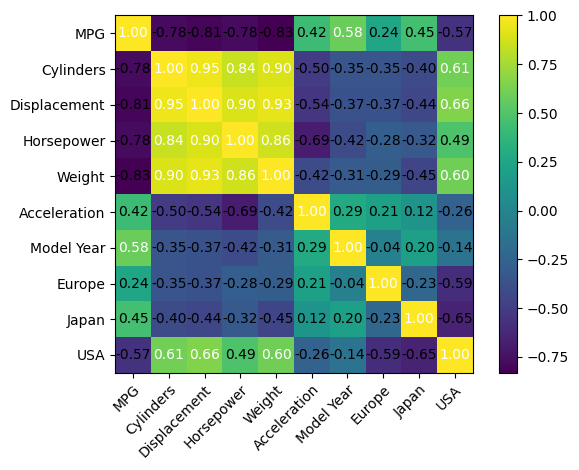

In [7]:
# The correlation matrix created with S.Raschka´s mlxtend library, provides the same results.
# Look at the first row where we compare the effect over MPG of the rest of the input variables.

from mlxtend.plotting import heatmap

cm = np.corrcoef(df_clean_copy.values.T)
hm = heatmap(cm, row_names = df_clean_copy.columns, column_names = df_clean_copy.columns)
plt.tight_layout()
plt.show()

## Model Creation

We are going to create the model by using the Functional API, preprocessing the data in the model

thanks to the Keras Preprocessing Layers:
[Keras Preprocessing Layers](https://keras.io/api/layers/preprocessing_layers/)

Another way would be by using Scikit-Learn StandardScaler,  KBinsDiscretizer, but doing it in this way we keep 
all together in the same model ready for deployment.


### Preprocessing With Keras Preprocessing Layers

As numerical inputs we have:
- cylinders: multi-valued discrete
- displacement: continuous
- horsepower: continuous
- weight: continuous
- acceleration: continuous

These inputs need to be standarized

The following ones:
- model year: multi-valued discrete
- origin: multi-valued discrete

Need to be treated in a different way in the Pipeline, the "model year" can be discretized (bucketized) in different bins, whereas the "origin" can be encoded using "One-Hot Vectors" or "Embeddings".

Some reference links:

https://keras.io/guides/preprocessing_layers/
https://www.tensorflow.org/guide/keras/preprocessing_layers
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb
https://github.com/ageron/handson-ml3/blob/main/13_loading_and_preprocessing_data.ipynb
https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#full_example
https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
https://www.tensorflow.org/recommenders/examples/deep_recommenders

NOTE:

In the example below, the origin is "one_hot_encoded" through the pandas get_dummies function

https://www.tensorflow.org/tutorials/keras/regression#regression_using_a_dnn_and_multiple_inputs

In [8]:
# Model inputs 

df_train_full, df_test = train_test_split(df_clean_copy, train_size = 0.8, random_state= 1)

# Extract features and targets and convert to arrays
X_full_train = df_train_full.iloc[:, 1:].values
y_full_train = df_train_full.iloc[:, 0].values

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

df_train, df_valid = train_test_split(df_train_full, train_size = 0.2, random_state = 1)

X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

X_valid = df_valid.iloc[:, 1:].values
y_valid = df_valid.iloc[:, 0].values

#### Create a baseline model using the Functional API

std_layer = keras.layers.Normalization(axis=-1)
std_layer.adapt(X_train[:,0:4])
std_layer(X_train[:,0:4])

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Input Layers
input_num = keras.layers.Input(shape = [9], name = 'numerical_features')


# It is needed to Standarize the numerical inputs, to discretize into buckets the 
# manufacturing year, and to embed or one-hot encode the numerical categorical features for
# the origin.
std_layer = keras.layers.Normalization(axis = -1)
norm_num= std_layer(input_num)
std_layer.adapt(X_train)

# We will create a model with 2 hidden Dense Layers and one output layer with one neuron

hidden1 = tf.keras.layers.Dense(64, activation="relu")(norm_num)
hidden2 = tf.keras.layers.Dense(64, activation="relu")(hidden1)
output = tf.keras.layers.Dense(1)(hidden2)

# So our model using the Functional API will be:
model_fapi = tf.keras.Model(inputs=[input_num], outputs=[output])

'''
The mean and variance values for the layer must be either supplied on construction or learned via adapt().
adapt() will compute the mean and variance of the data and store them as 
the layer's weights. adapt() should be called before fit(), evaluate(), or predict().

https://keras.io/guides/preprocessing_layers/#the-adapt-method
'''
#std_layer.adapt(X_train[:,0:4])
#bucket_layer.adapt(X_train[:,5])

# Preprocessed Tensors
print(norm_num)

print(std_layer.mean.numpy())

# Select Optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_fapi.compile(loss="mse", optimizer=optimizer, metrics = 'RootMeanSquaredError')

# Train the model with the normalized and bucketized features
history = model_fapi.fit(X_train, y_train, epochs=200,
validation_data=(X_valid, y_valid),verbose = 0)

KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
[[5.4677420e+00 1.9158064e+02 1.0580645e+02 2.9686128e+03 1.5490323e+01
  7.5629028e+01 1.1290322e-01 3.3870965e-01 5.4838705e-01]]


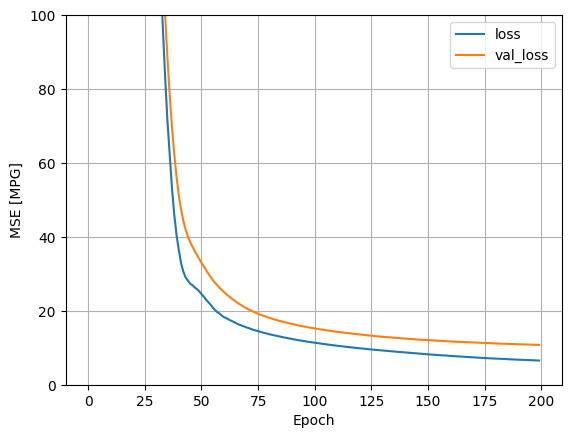

In [37]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('MSE [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [38]:
model_fapi.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numerical_features (InputLa  [(None, 9)]              0         
 yer)                                                            
                                                                 
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable par

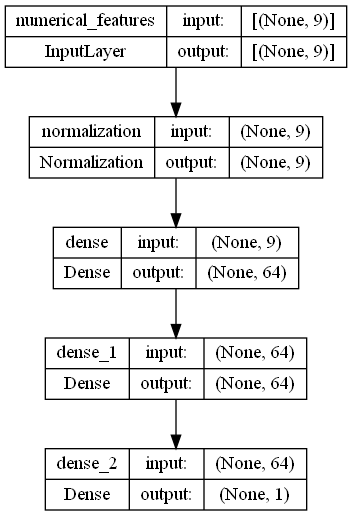

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model_fapi, 'MPG_Regressor.png', show_shapes = True)

In [13]:
print(std_layer.mean.numpy())
print(std_layer.variance.numpy())

[[5.4677420e+00 1.9158064e+02 1.0580645e+02 2.9686128e+03 1.5490323e+01
  7.5629028e+01 1.1290322e-01 3.3870965e-01 5.4838705e-01]]
[[3.0554109e+00 1.0689501e+04 1.5307367e+03 7.1404556e+05 8.1024866e+00
  1.1362382e+01 1.0015608e-01 2.2398543e-01 2.4765873e-01]]


## Model Evaluation

In [39]:
# Evaluate and do some predictions

mse_test = model_fapi.evaluate(X_valid, y_valid)
y_pred = model_fapi.predict(X_test)

3/3 [==============================] - 0s 6ms/step


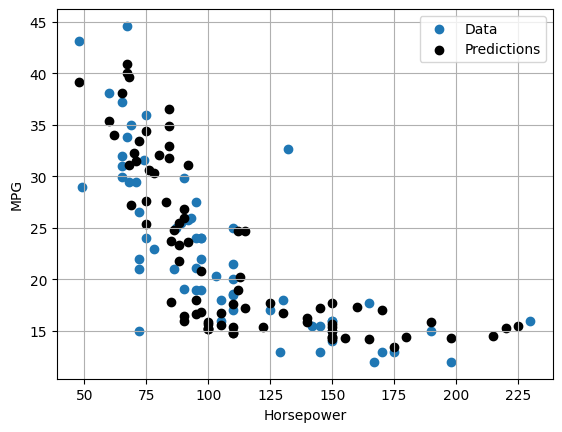

In [40]:
def plot_horsepower(x, y):
  plt.scatter(X_train[:,2], y_train, label='Data')
  plt.scatter(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.grid(True)
  plt.legend()

plot_horsepower(X_test[:,2],y_pred)

## Save Basic Model

In [41]:
# Basic Model
model_fapi.save('AutoMPG_model_all_inputs_w_Normalization.h5')

## Model Optimization with Keras Tuner

In [109]:
import keras_tuner as kt
tf.keras.backend.clear_session()
tf.random.set_seed(42)
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=3, default=2)
    n_neurons = hp.Int("n_neurons", min_value=8, max_value=64)
    learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-1,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd","adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    
    norm_layer = tf.keras.layers.Normalization()
    model = tf.keras.models.Sequential([
        norm_layer
        ])
    model.add(norm_layer)
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=optimizer,
                  metrics=[keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
# To make the search to work properly the objective val has to be derived 
# from the metrics in the build_model
random_search_tuner = kt.RandomSearch(
    build_model, objective = kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=2, overwrite=True,seed=42)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

random_search_tuner.search(X_train, y_train, epochs=20,
                           validation_data=(X_valid, y_valid), batch_size = 32 ,verbose = 1, 
                           callbacks = [stop_early])

In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [113]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values


{'n_hidden': 2,
 'n_neurons': 10,
 'learning_rate': 0.006562536901904111,
 'optimizer': 'adam'}

## Run Optimized Model

In [114]:
best_model.fit(X_full_train, y_full_train, epochs=100)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/100
10/10 [==============================] - 0s 4ms/step - loss: 21.0014 - root_mean_squared_error: 4.5827
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 23.1071 - root_mean_squared_error: 4.8070
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 22.6981 - root_mean_squared_error: 4.7643
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 22.4529 - root_mean_squared_error: 4.7384
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 20.3440 - root_mean_squared_error: 4.5104
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 20.6664 - root_mean_squared_error: 4.5460
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 21.6172 - root_mean_squared_error: 4.6494
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 20.4370 - root_mean_squared_error: 4.5207
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 20.8763

In [115]:
y_pred = best_model.predict(X_test)

3/3 [==============================] - 0s 4ms/step


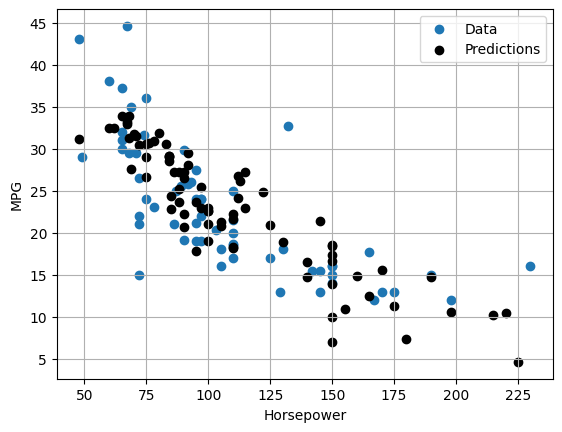

In [116]:
def plot_horsepower(x, y):
  plt.scatter(X_train[:,2], y_train, label='Data')
  plt.scatter(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.grid(True)
  plt.legend()

plot_horsepower(X_test[:,2],y_pred)

Comment:

There are problems to run Keras Tuner, and it is clear that the optimized model does not perform better than the previous one.

## Save Optimized Model

In [117]:
# Basic Model
model_fapi.save('AutoMPG_model_all_inputs_w_Normalization.h5')
# Optimized Model
best_model.save('AutoMPG_model_all_inputs_w_Normalization_Optimized.h5')